In [19]:
import pandas as pd
import numpy as np
from fastai.data.all import *
from fastai.vision.all import *
from PIL import Image
import plotly.express as px
import os

Magnetic resonance imaging (MRI) is a medical imaging technique that uses a strong magnetic field and radio waves to produce detailed images of the body's internal structures. Because it can produce precise images of the brain's soft tissue, it is frequently employed in the diagnosis of brain cancers.

Machine learning techniques can analyse vast volumes of imaging data and spot patterns that may be challenging for human experts to see. To improve the precision and effectiveness of methods for diagnosing brain tumours, researchers are now finding ways to train machine learning models on vast datasets of MRI scans.

This project will utilise the highly efficient deep learning package *fastai*  (https://github.com/fastai/fastai) which is built on top of the *PyTorch* library, as I am currently studying deep learning using the *fast.ai* course and would like to supplement my learning through the building of a project.

In [17]:
# Load dataset
data_dir1 = 'Datasets/brain_tumor_dataset'
data_dir2 = 'Datasets/brain_tumor_dataset2'

# Check the labels for each MRI photo, between each dataset
print(os.listdir(f'{data_dir1}'))
print(os.listdir(f'{data_dir2}'))

# Create dictionary to map label to unified label
labeller = {'yes': 'Tumour', 'Brain Tumor': 'Tumour', 'no': 'No Tumour', 'Healthy': 'No Tumour'}

# Merge the two datasets and change labels between datasets using parent_label from fastai
df = pd.DataFrame({'image':(*get_image_files(data_dir1), *get_image_files(data_dir2))})
df['label'] = df.apply(lambda x: labeller[parent_label(x.image)], 'columns')
df['size'] = df.apply(lambda x: Image.open(x.image).size, 'columns')

df.head()

['no', 'yes']
['Brain Tumor', 'Healthy']


,image,label,size
0,Datasets\brain_tumor_dataset\no\1 no.jpeg,No Tumour,"(630, 630)"
1,Datasets\brain_tumor_dataset\no\10 no.jpg,No Tumour,"(173, 201)"
2,Datasets\brain_tumor_dataset\no\11 no.jpg,No Tumour,"(300, 168)"
3,Datasets\brain_tumor_dataset\no\12 no.jpg,No Tumour,"(275, 183)"
4,Datasets\brain_tumor_dataset\no\13 no.jpg,No Tumour,"(300, 168)"


We have two separate datasets containing MRI images that have been classified as having a brain tumour (yes/Brain Tumour folder) or not (no/Healthy folder), which we have merged together and unified labels so that they are either labelled 'Tumour' or 'No Tumour'. This merged dataset will form the full dataset used to train and validate the deep learning model. The image size has also been outputted as we would like to standardise this.

### How many images do we have for each diagnosis?

In [18]:
df.value_counts('label')

label
Tumour       2668
No Tumour    2185
dtype: int64

The dataset doesn't contain an equal number of images for each diagnosis.

### What's the variation in image sizes?
We require the images to be of the same size because this means the images will collate well with the tensors of the model when trained upon.

In [74]:
w, h = list(zip(*df['size'].values)) # Unzip list into width and height using zip() and *

sizesdata = pd.DataFrame({'width':w, 'height':h, 'label':df['label'].values})

fig = px.scatter(sizesdata, x = w, y = h, color = 'label', labels={'x':'Width', 'y':'Height', 'label':'Diagnosis'}, height = 550, width = 700, title = 'Distribution of Image Width and Height', marginal_x = 'histogram', marginal_y = 'histogram')
fig.show()

To utilise *fastai* for image classification, we first need to build a *DataBlock*, which is an object containing the structure of the inputs and labels that we feed into the deep learning algorithm. A *DataBlock* requires us to specify how large we want the training and validation sets to be. We'll also indicate that we want to perform data augmentation by resizing the images to the same size (400, 400) using the 'squish' method. After the *DataBlock* is defined, we can feed our pandas DataFrame into a *DataLoaders* object which acts as a data-filled input in the structure of our *DataBlock*.

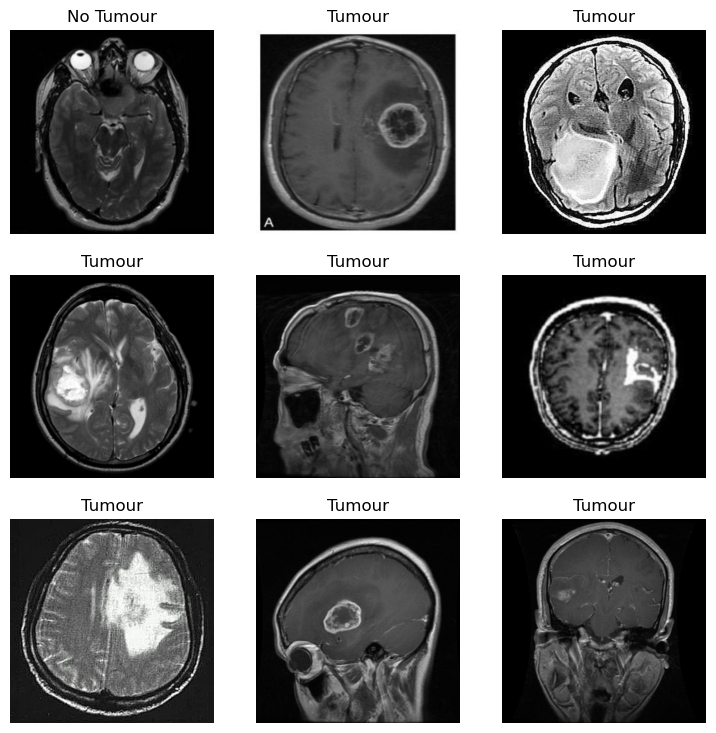

In [99]:
dblock = DataBlock.from_columns(blocks = (ImageBlock, CategoryBlock),
    get_items = lambda x: (x.image, x.label), # Our input is the image path and the label is already in the dataset, so we output these (this acts like the .apply method)
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # We set aside 20% of the dataset to be the validation set, the remaining 80% makes up the training set.
    item_tfms = Resize(400, method = 'squish'))

dloaders = dblock.dataloaders(df) # Feed df into a dataloaders following the structure of the DataBlock defined above

dloaders.valid.show_batch(max_n = 9) # Show batches of dataset